# Libraries

In [ ]:
!pip install torchbearer


     |████████████████████████████████| 143kB 7.5MB/s 


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import FashionMNIST

import torchbearer
import torchbearer.callbacks as callbacks
from torchbearer import Trial, state_key

MU = state_key('mu')
LOGVAR = state_key('logvar')

# VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 1, 2),   # B,  32, 28, 28
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),  # B,  32, 14, 14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),  # B,  64,  7, 7
        )
        
        self.mu = nn.Linear(64 * 7 * 7, latent_size)
        self.logvar = nn.Linear(64 * 7 * 7, latent_size)
        
        self.upsample = nn.Linear(latent_size, 64 * 7 * 7)
        self.decoder_mu = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  64,  14,  14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1, 1), # B,  32, 28, 28
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 1, 2)   # B, 1, 28, 28
        )
        self.decoder_logvar = nn.Sequential(
            nn.Linear(64 * 7 * 7, 28)
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def reparameterize_decoder(self, mu, logvar):
        if self.training:
            std = torch.diag_embed(torch.exp(0.5*logvar)).unsqueeze(1)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu, logvar

    def forward(self, x, state):
        image = x
        
        sample, mu, logvar = self.forward_encoder(x)
        result = self.forward_decoder(sample)

        if state is not None:
            state[torchbearer.Y_TRUE] = image
            state[MU] = mu
            state[LOGVAR] = logvar
        
        return result

    def forward_encoder(self, x):
        x = self.encoder(x).relu().view(x.size(0), -1)
        
        mu = self.mu(x)
        logvar = self.logvar(x)
        return self.reparameterize(mu, logvar), mu, logvar

    def forward_decoder(self, x):
        z = self.upsample(x).relu()
        dec_mu = self.decoder_mu(z.view(-1, 64, 7, 7)) # Decoder Mean
        dec_logvar = self.decoder_logvar(z) # Decoder Variance

        return self.reparameterize_decoder(dec_mu, dec_logvar)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])  # No augmentation
trainset = FashionMNIST(root='./', train=True, transform=transform, download=True)
testset = FashionMNIST(root='./', train=False, transform=transform, download=True)
traingen = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([trainset, testset]), batch_size=128, shuffle=True, num_workers=2)


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def beta_kl(mu_key, logvar_key, beta=5):
    @callbacks.add_to_loss
    def callback(state):
        mu = state[mu_key]
        logvar = state[logvar_key]
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta
    return callback

In [ ]:
def plot_progress(key=torchbearer.Y_PRED, num_images=100, nrow=10):
    @callbacks.on_step_validation
    @callbacks.once_per_epoch
    def callback(state):
        images = state[key]
        image = make_grid(images[:num_images], nrow=nrow, normalize=True)[0, :, :]
        plt.imshow(image.detach().cpu().numpy(), cmap="gray")
        plt.show()
    
    return callback

In [ ]:
model = VAE(latent_size=10)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)
trial = Trial(model, 
              optimizer, 
              nn.MSELoss(reduction='sum'), 
              metrics=['acc', 'loss'], 
              callbacks=[
                            beta_kl(MU, LOGVAR),
                            callbacks.ConsolePrinter(),
                            plot_progress()
                        ], 
              verbose=1).with_generators(train_generator=traingen)

trial.to('cuda')
trial.run(20)
trial.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)

0/20(t): loss=7522.7119, mse=0.0637, running_loss=6173.0723, running_mse=0.0463
1/20(t): loss=5942.543, mse=0.0431, running_loss=5840.291, running_mse=0.0416
2/20(t): loss=5745.3022, mse=0.0401, running_loss=5717.499, running_mse=0.0397
3/20(t): loss=5661.4995, mse=0.0389, running_loss=5619.6069, running_mse=0.0384
4/20(t): loss=5609.4849, mse=0.0382, running_loss=5574.9893, running_mse=0.0377
5/20(t): loss=5566.9336, mse=0.0376, running_loss=5535.4536, running_mse=0.0373
6/20(t): loss=5535.771, mse=0.0371, running_loss=5574.124, running_mse=0.0373
7/20(t): loss=5519.6196, mse=0.0368, running_loss=5497.8574, running_mse=0.0364
8/20(t): loss=5498.1021, mse=0.0364, running_loss=5487.6172, running_mse=0.0363
9/20(t): loss=5480.3726, mse=0.0362, running_loss=5463.2817, running_mse=0.0357
10/20(t): loss=5476.6514, mse=0.036, running_loss=5482.5781, running_mse=0.0361
11/20(t): loss=5464.7769, mse=0.0359, running_loss=5434.5361, running_mse=0.0353
12/20(t): loss=5449.6509, mse=0.0357, runnin

{}

# Geo Code

In [ ]:
! git clone https://github.com/MachineLearningLifeScience/stochman
! mv stochman stochman2
! mv  stochman2/stochman stochman
! rm -rf stochman2

Cloning into 'stochman'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (312/312), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 312 (delta 176), reused 233 (delta 108), pack-reused 0
Receiving objects: 100% (312/312), 469.11 KiB | 1.93 MiB/s, done.
Resolving deltas: 100% (176/176), done.


In [ ]:
from stochman import manifold, geodesic, utilities
from stochman.curves import BasicCurve, CubicSpline

class geoDecoder(manifold.EmbeddedManifold):
    def __init__(self, decoder, **kwargs):
        super(geoDecoder).__init__(**kwargs)
        self.decoder = decoder

    def embed(self, points): # works for only 1 image in batch
        #print('Curve points shape', points.shape)
        B = points.shape[0]
        N = points.shape[1]
        decode = self.decoder(points[0])
        #print('After decoder shape', decode.shape)
        decode = decode.reshape([B, N, -1])
        #print('After reshaping shape', decode.shape)
        return decode
    
    #def embed(self, points, jacobian=False):
    #    decode =  torch.cat([torch.reshape(self.decoder(points[idx]), (points.shape[0], -1)).unsqueeze(0) for idx in range(points.shape[0])], 0)
    #    print(decode.shape)
    #    return decode
    
    def curve_energy(self, curve: BasicCurve, dt=None):
        """
        Compute the discrete energy of a given curve.
        Input:
            curve:      a Nx(d) torch Tensor representing a curve or
                        a BxNx(d) torch Tensor representing B curves.
        Output:
            energy:     a scalar corresponding to the energy of
                        the curve (sum of energy in case of multiple curves).
                        It should be possible to backpropagate through
                        this in order to compute geodesics.
        Algorithmic note:
            The algorithm rely on the deterministic embedding of the manifold
            rather than the metric. This is most often more efficient.
        """
        if curve.dim() == 2:
            curve.unsqueeze_(0)  # add batch dimension if one isn't present
        if dt is None:
            dt = curve.shape[1] - 1
            
        # Now curve is BxNx(d)
        emb_curve = self.embed(curve)  # BxNxD
        B, N, D = emb_curve.shape
        delta = emb_curve[:, 1:, :] - emb_curve[:, :-1, :]  # Bx(N-1)xD
        energy = (delta ** 2).sum((1, 2)) * dt  # B
        
        #print(energy) # to see value going down
        
        return energy
    
    ## Here I redefined this to change the predefined values of the optimization function
    
    def connecting_geodesic(self, p0, p1, init_curve= None):
        """
        Compute geodesic connecting two points.
        Args:
            p0: a torch Tensor representing the initial point of the requested geodesic.
            p1: a torch Tensor representing the end point of the requested geodesic.
            init_curve: a curve representing an initial guess of the requested geodesic.
                If the end-points of the initial curve do not correspond to p0 and p1,
                then the curve is modified accordingly. If None then the default constructor
                of the chosen curve family is applied.
        """
        if init_curve is None:
            curve = CubicSpline(p0, p1)
        else:
            curve = init_curve
            curve.begin = p0
            curve.end = p1

        curve_initial = curve
        # success = geodesic_minimizing_energy_sgd(curve, self)
        success = geodesic.geodesic_minimizing_energy(curve, self, max_iter = 300, eval_grid = 20)
        
        return curve_initial, curve, success

# Post Training Stuff

In [ ]:
from sklearn.decomposition import PCA

required_idx = lambda xl, xr, yl, yr: np.arange(0, img_embeddings_r2.shape[0],1)[(img_embeddings_r2[:,0] > xl) * \
                                                                                 (img_embeddings_r2[:,0] < xr) * \
                                                                                 (img_embeddings_r2[:,1] > yl) * \
                                                                                 (img_embeddings_r2[:,1] < yr)]

In [ ]:
# Sampling Images

model = model.cpu();
model.train(False);

N = 15
img_embeddings = torch.cat([model.forward_encoder(next(iter(traingen))[0])[1] for _ in range(N)], axis=0)

In [ ]:
# Getting Image Embeddings in Latent Space

_, imgs_var = model.forward_decoder(img_embeddings)

In [ ]:
# PCA of Embeddings in LAtent Space
pca = PCA(2)

img_embeddings_r2 = pca.fit_transform(torch.clone(img_embeddings).detach().cpu().numpy())

In [ ]:
# L2 Norm of Covariance Matrix

imgs_var_norm = torch.sqrt(torch.sum(torch.exp(0.5*imgs_var)**2, axis=1)).detach().cpu().numpy()

In [ ]:
# Get Required Points Indices

required_idx(-2, -1, -0.5, 0.5)

array([   1,    7,    8,   10,   33,   37,   42,   44,   45,   67,   97,
        102,  117,  149,  171,  175,  180,  197,  213,  216,  223,  259,
        266,  301,  304,  317,  323,  346,  349,  363,  400,  406,  428,
        454,  457,  476,  487,  488,  492,  493,  501,  505,  520,  522,
        523,  526,  527,  534,  539,  548,  580,  588,  611,  627,  628,
        652,  654,  700,  703,  735,  737,  770,  780,  809,  814,  857,
        864,  868,  875,  893,  899,  909,  926,  945,  947,  953,  964,
        999, 1031, 1043, 1056, 1061, 1083, 1092, 1107, 1117, 1150, 1152,
       1164, 1182, 1200, 1219, 1231, 1241, 1242, 1269, 1342, 1351, 1377,
       1386, 1387, 1460, 1472, 1485, 1506, 1511, 1514, 1520, 1529, 1597,
       1620, 1622, 1625, 1630, 1647, 1659, 1667, 1691, 1695, 1710, 1712,
       1728, 1809, 1826, 1834, 1844, 1855, 1870, 1871, 1880, 1906, 1911,
       1917, 1919])

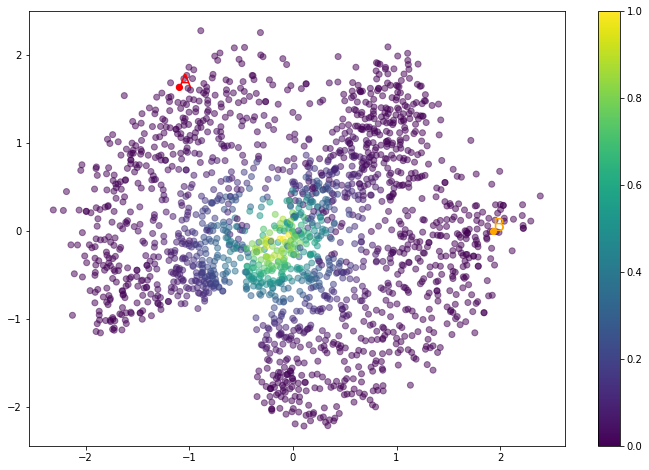

In [ ]:
# Choose point to connect using Geodesic

a_idx, b_idx = 39, 52

plt.figure(figsize=(12, 8))
plt.scatter(img_embeddings_r2[:,0], img_embeddings_r2[:,1], c=imgs_var_norm, alpha=0.5)
plt.scatter(img_embeddings_r2[a_idx,0], img_embeddings_r2[a_idx,1],  color="red")
plt.scatter(img_embeddings_r2[b_idx,0], img_embeddings_r2[b_idx,1],  color="orange")
plt.text(img_embeddings_r2[a_idx,0], img_embeddings_r2[a_idx,1], "A", color="red", fontsize=18)
plt.text(img_embeddings_r2[b_idx,0], img_embeddings_r2[b_idx,1], "B", color="orange", fontsize=18)
plt.colorbar()
plt.show()

In [ ]:
# Calcualte Geodesic

model = model.cpu();
model.train();

geom = geoDecoder(decoder = model.forward_decoder)
curve_initial, curve, success = geom.connecting_geodesic(img_embeddings[a_idx].cpu(), img_embeddings[b_idx].cpu())
a_ = torch.cat([torch.ones(1,1)*i/10 for i in range(11)], axis=1)
cp = curve.forward(a_)

geodesic_r2 = pca.transform(cp.detach().numpy().squeeze())

In [ ]:
# Geodesic Length

geom.curve_length(cp)

tensor([17.4308], grad_fn=<MulBackward0>)

In [ ]:
# Linear Length

curve_initial.euclidean_length()

tensor([13.1135], grad_fn=<SumBackward1>)

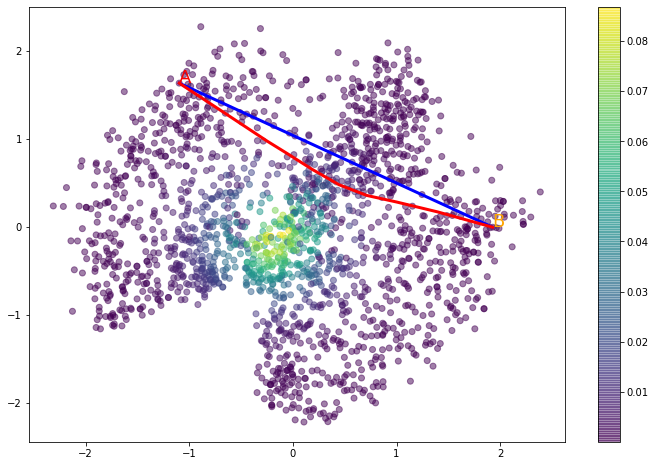

In [ ]:
# Plot Geodesic

plt.figure(figsize=(12, 8))
plt.scatter(img_embeddings_r2[:,0], img_embeddings_r2[:,1], c=imgs_var_norm, alpha=0.5)
plt.text(img_embeddings_r2[a_idx,0], img_embeddings_r2[a_idx,1], "A", color="red", fontsize=18)
plt.text(img_embeddings_r2[b_idx,0], img_embeddings_r2[b_idx,1], "B", color="orange", fontsize=18)
plt.plot([img_embeddings_r2[a_idx,0], img_embeddings_r2[b_idx,0]], [img_embeddings_r2[a_idx,1], img_embeddings_r2[b_idx,1]],  color="blue", linewidth=3)
plt.plot(geodesic_r2[:,0], geodesic_r2[:, 1], color="red", linewidth=3)
plt.colorbar()
plt.show()

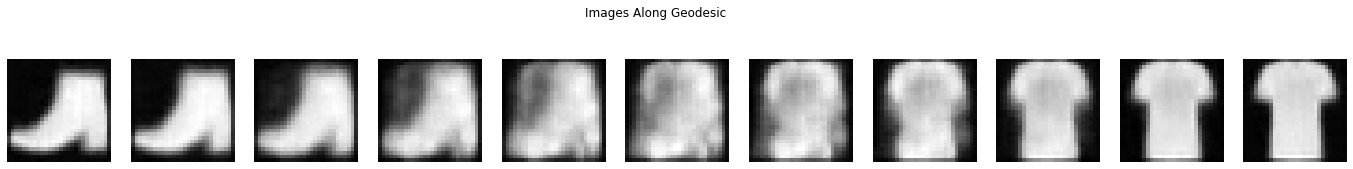

In [ ]:
# Images along the Geodesics between two latent embeddings.

img_plot = model.forward_decoder(cp[0]).detach().cpu().numpy().squeeze()

plt.figure(figsize=(24, 3))
for i, x in enumerate(img_plot):
    plt.subplot(1, 11, i+1)
    plt.imshow(x, cmap="gray")
    plt.axis("off")
plt.suptitle("Images Along Geodesic")
plt.show()

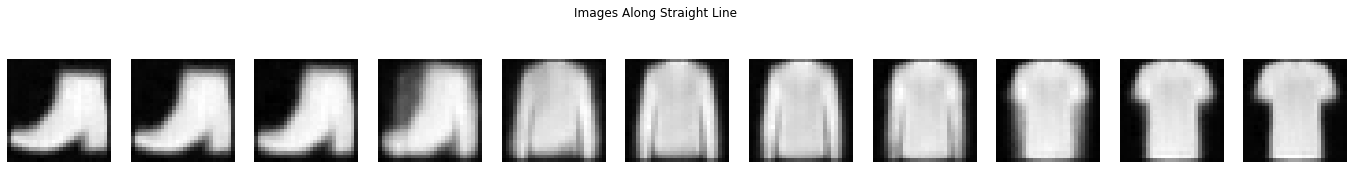

In [ ]:
# Images Along the Linear Interpolation b/n two latent embeddings.

img_grad = img_embeddings[b_idx].cpu() - img_embeddings[a_idx].cpu()
imgs_euclid = []
for i in range(11):
    imgs_euclid.append((img_embeddings[a_idx].cpu() + img_grad*i/11).unsqueeze(0))

imgs_euclid =  model.forward_decoder(torch.cat(imgs_euclid)).detach().cpu().numpy().squeeze()

plt.figure(figsize=(24, 3))
for i, x in enumerate(imgs_euclid):
    plt.subplot(1, 11, i+1)
    plt.imshow(x, cmap="gray")
    plt.axis("off")
plt.suptitle("Images Along Straight Line")
plt.show()